<a href="https://colab.research.google.com/github/tleitch/BDML/blob/main/Chateau%20Winery/wine_classificationCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparing Dataset for Classification**

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import minmax_scale  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.lines import Line2D


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Added for Assignment
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from nltk.cluster.util import cosine_distance
from sklearn import preprocessing
import os
from xgboost import XGBClassifier



In [2]:
# Functions

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
# Showing Incorrect Classification
def plot_comp_test_data(X_test, y_test, y_head, title):
    plt.figure(figsize=(12,6))
    plt.scatter(X_test[:,0], X_test[:,6], c=[colors[i] for i in y_head], marker="*", s=60)
    n = np.size(y_head)
    for i in range(0, n):
        if y_head[i] != y_test[i]:
            plt.scatter(X_test[i,0], X_test[i,6], c=[colors[y_test[i]]], marker="X", s=120, alpha=.4)
    legend_elements = [Line2D([0], [0], marker='*', color='w', label='Prediction', markerfacecolor='k', markersize=14),
                       Line2D([0], [0], marker='X', color='w', label='Correct Class', markerfacecolor='k', markersize=12)]
    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.show()

In [3]:
# Defining dataset and browsing content
data = pd.read_csv('https://raw.githubusercontent.com/tleitch/BDML/main/Chateau%20Winery/wine.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Wine                    178 non-null int64
Alcohol                 178 non-null float64
Malic.acid              178 non-null float64
Ash                     178 non-null float64
Acl                     178 non-null float64
Mg                      178 non-null int64
Phenols                 178 non-null float64
Flavanoids              178 non-null float64
Nonflavanoid.phenols    178 non-null float64
Proanth                 178 non-null float64
Color.int               178 non-null float64
Hue                     178 non-null float64
OD                      178 non-null float64
Proline                 178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [4]:
# Show first 10 sample
data.tail(10)

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
168,3,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.660000,0.74,1.80,750
169,3,13.40,4.60,2.86,25.0,112,1.98,0.96,0.27,1.11,8.500000,0.67,1.92,630
170,3,12.20,3.03,2.32,19.0,96,1.25,0.49,0.40,0.73,5.500000,0.66,1.83,510
171,3,12.77,2.39,2.28,19.5,86,1.39,0.51,0.48,0.64,9.899999,0.57,1.63,470
172,3,14.16,2.51,2.48,20.0,91,1.68,0.70,0.44,1.24,9.700000,0.62,1.71,660
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.700000,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.300000,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.200000,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.300000,0.60,1.62,840
177,3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.200000,0.61,1.60,560


In [5]:
# Split data : X(feature) and y(target) 
X = np.array(data.drop(['Wine'],1))
y = np.array(data['Wine'])
np.shape(y)

(178,)

No handles with labels found to put in legend.


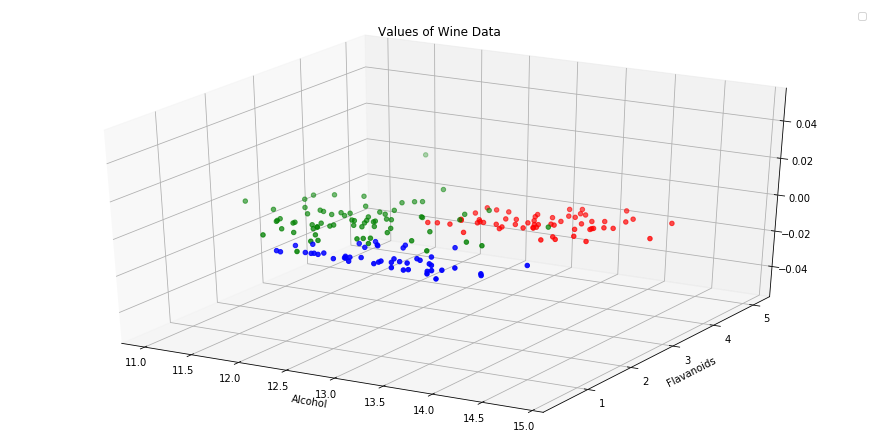

In [6]:
# Visualization Data
fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig)
colors = {1:"r", 2:"g", 3:"b"}
ax.scatter(X[:,0], X[:,6], c=[colors[i] for i in y])
ax.set_xlabel("Alcohol")
ax.set_ylabel("Flavanoids")
plt.title("Values of Wine Data")
ax.legend()
plt.show()

In [7]:
# scaling each feature to a 0 to 1
X = minmax_scale(X)

In [8]:
# Create Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (133, 13)
y_train (133,)
X_test (45, 13)
y_test (45,)


Text(0, 0.5, 'Average Silhouette Score')

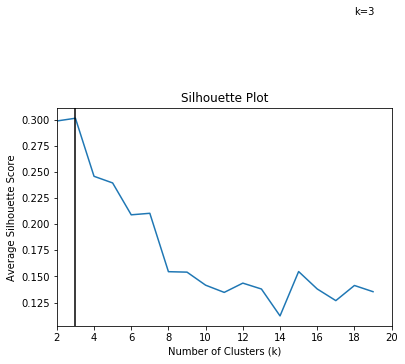

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_scores = [] # Initialize empty list to store silhouette scores

# Loop over different values of k and calculate the average silhouette score
for i in range(2, 20):
    
    # Initialize clustering with k = i
    kmeansI = KMeans(n_clusters=i, random_state=817910)
    
    # Apply clustering
    kmeansI.fit(X)
    
    # Calculate the silhouette score when k = i
    labelsI = kmeansI.fit_predict(X)
    scoreI = silhouette_score(X, labelsI)
    
    # Add silhouette score at k = i to silhouette_scores
    silhouette_scores.append((i, scoreI))
    
# Plot the average silhouette score for each value of k
x1,y1 = zip(*silhouette_scores)
plt.plot(x1, y1)

# Plot a vertical line at whichever k maximizes the silhouette score
maxK = x1[y1.index(max(y1))]
plt.axvline(x=maxK, color="black")
plt.text(18, 0.4, 'k='+str(maxK), color='black')

# Label the chart and the x and y axes
plt.title("Silhouette Plot")
plt.xlabel("Number of Clusters (k)")
plt.xlim([2,20])
plt.ylabel("Average Silhouette Score")

## **k-Nearest Neighbors (k-NN) Classification**

In [10]:
# Create k-NN classification model with GridSearchCV
# n_neighbors: Number of neighbors to use
# weights: weights is used for distance function (uniform: All points in each neighborhood are weighted equally ||
#                                                 distance: Weight points by the inverse of their distance.)
# p: Power parameter for calculate distance. (1: Manhattan Distance. 2: Eucledian Distance. 3 and upper: Minkowski Distance.)
knn_grid = {"n_neighbors":np.arange(1,15), "weights":["uniform", "distance"], "p":[1, 2, 3] }
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=10, iid=False)
knn.fit(X_train, y_train)

print("k-NN Tuned Hyperparameters", knn.best_params_)
print("k-NN Tuned Best Score:", round(knn.best_score_,3))

k-NN Tuned Hyperparameters {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
k-NN Tuned Best Score: 0.977


In [11]:
# Use best classification model
best_clf_knn = knn.best_estimator_
best_clf_knn.fit(X_train, y_train)
knn_y_head = best_clf_knn.predict(X_test)
print("k-Nearest Neighbors (k-NN) Classification Accuracy: {}%" .format(round(best_clf_knn.score(X_test, y_test)*100,2)))

k-Nearest Neighbors (k-NN) Classification Accuracy: 95.56%


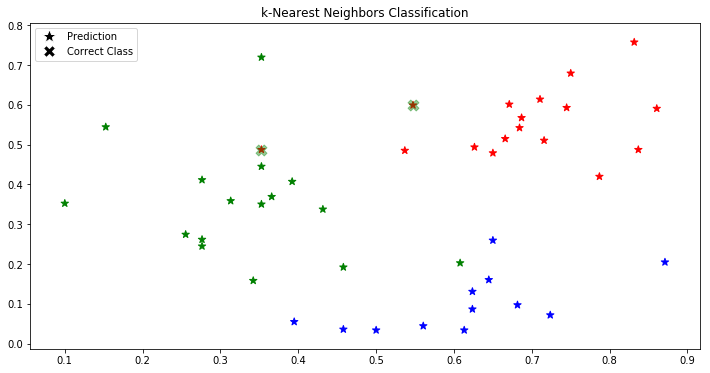

In [12]:
# Show Incorrect Classification
plot_comp_test_data(X_test, y_test, knn_y_head,title="k-Nearest Neighbors Classification")

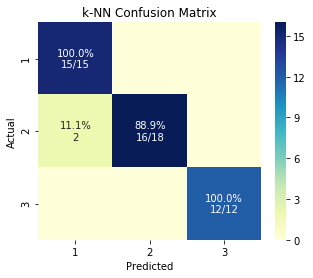

In [13]:
# Show Confusion Matrix
plot_cm(y_test, knn_y_head, title="k-NN Confusion Matrix")

**KNN CV example code here**

In [14]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Accuracy: 0.963 (0.032)


In [15]:
scores

array([0.97222222, 0.97222222, 0.94444444, 0.97142857, 0.97142857,
       0.97222222, 0.86111111, 0.97222222, 1.        , 0.94285714,
       0.97222222, 0.97222222, 0.94444444, 1.        , 0.97142857])

**Hw Part 1 - Using knn cross valididated example, add  CV analysis to DT and random Forest**

## ** Decision Tree (DT) Classification**

In [16]:
# Create DT classification model with GridSearchCV
# criterion: The function to measure the quality of a split. (Gini: Gini impurity. || Entropy: Information gain)
# min_samples_split: The minimum number of samples required to split an internal node.
# min_samples_leaf: The minimum number of samples required to be at a leaf node.
dtree_grid = {"criterion":["gini", "entropy"], "min_samples_split":[3,4,5,6,7,8,9,10], "min_samples_leaf":[1,2,3,4,5,6,7,8,9]}
dtree = GridSearchCV(DecisionTreeClassifier(random_state=42), dtree_grid, cv=10, iid=False)
dtree.fit(X_train, y_train)

print("DT Tuned Hyperparameters", dtree.best_params_)
print("DT Tuned Best Score:", round(dtree.best_score_,3))

DT Tuned Hyperparameters {'criterion': 'gini', 'min_samples_leaf': 8, 'min_samples_split': 3}
DT Tuned Best Score: 0.956


In [17]:
# Use best classification model
best_clf_dt = dtree.best_estimator_
best_clf_dt.fit(X_train, y_train)
dtree_y_head = best_clf_dt.predict(X_test)
print("Decision Tree (DT) Classification Accuracy: {}%" .format(round(best_clf_dt.score(X_test, y_test)*100,2)))

Decision Tree (DT) Classification Accuracy: 93.33%


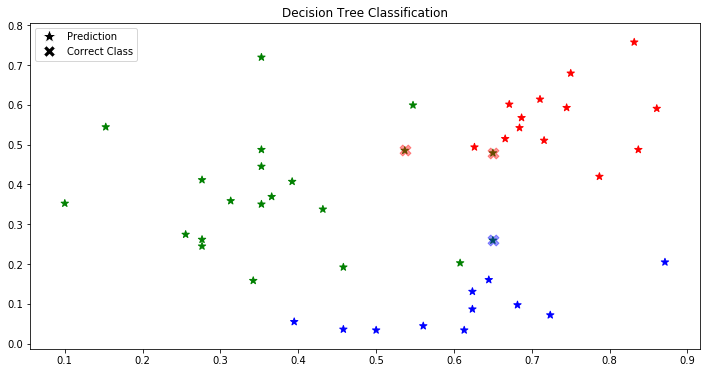

In [18]:
# Show Incorrect Classification
plot_comp_test_data(X_test, y_test, dtree_y_head, title="Decision Tree Classification")

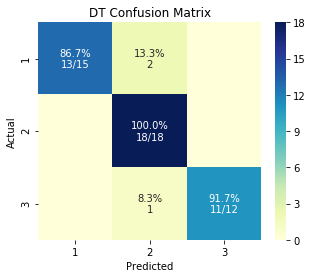

In [19]:
# Show Confusion Matrix 
plot_cm(y_test, dtree_y_head, title="DT Confusion Matrix")

**DT CV Analysis Here**

In [20]:
scores_dt = cross_val_score(dtree, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_dt), np.std(scores_dt)))

Accuracy: 0.918 (0.051)


In [21]:
scores_dt

array([0.94444444, 0.94444444, 0.91666667, 0.91428571, 0.88571429,
       0.91666667, 0.80555556, 0.94444444, 0.97142857, 0.97142857,
       0.94444444, 0.80555556, 0.94444444, 0.97142857, 0.88571429])

## ** Random Forest (RF) Classification**

In [22]:
# Create RF classification model with GridSearchCV
# n_estimators: The number of trees in the forest.
# criterion, min_samples_split and min_samples_leaf are same to decision tree parameters.
rf_grid = {"n_estimators": [50, 100, 150], "criterion": ["gini", "entropy"],
           "min_samples_split":[3,4,5,6,7,8,9,10], "min_samples_leaf":[1,2,3,4,5,6,7,8,9]}
rforest = GridSearchCV(RandomForestClassifier(random_state=42), rf_grid, cv=10, iid=False)
rforest.fit(X_train, y_train)

print("RF Tuned Hyperparameters", rforest.best_params_)
print("RF Tuned Best Score:", round(rforest.best_score_,3))

RF Tuned Hyperparameters {'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
RF Tuned Best Score: 0.985


In [23]:
best_clf_rforest = rforest.best_estimator_
best_clf_rforest.fit(X_train, y_train)
rforest_y_head = best_clf_rforest.predict(X_test)
print("Random Forest (RF) Classification Accuracy: {}%" .format(round(best_clf_rforest.score(X_test, y_test)*100,2)))

Random Forest (RF) Classification Accuracy: 97.78%


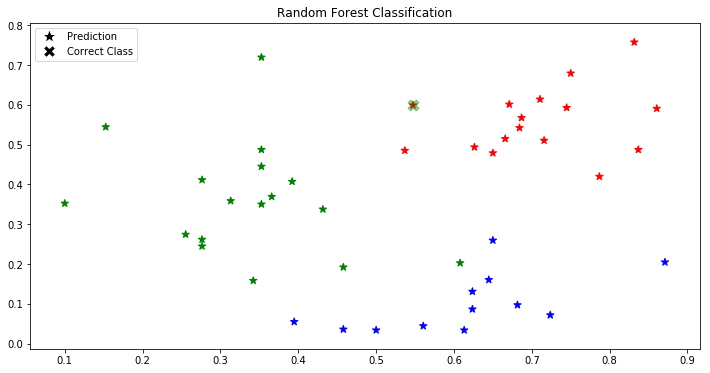

In [24]:
#Show Incorrect Classification
plot_comp_test_data(X_test, y_test, rforest_y_head, title="Random Forest Classification")

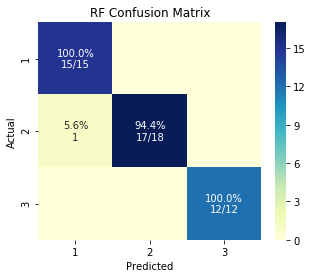

In [25]:
# Show Confusion Matrix
plot_cm(y_test, rforest_y_head, title="RF Confusion Matrix")

 *RF CV Analysis here*

In [26]:
scores_rf = cross_val_score(rforest, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_rf), np.std(scores_rf)))

Accuracy: 0.987 (0.014)


In [29]:
scores_rf

array([0.97222222, 1.        , 0.97222222, 1.        , 0.97142857,
       1.        , 0.97222222, 1.        , 1.        , 0.97142857,
       0.97222222, 0.97222222, 1.        , 1.        , 1.        ])

How do they compare using CV vs simple train/test split?

Two disadvantages of simple train/test split:
1.The selection of final model and parameters will largely depend on how you divide the training set and test set
2.This method only uses part of the data to train the model. The larger the amount of data used for model training, the better the effect of the trained model. The division of train set and test set means that we can't make full use of the data we have, so the model effect will be affected to some extent.

CV,for example, K-fold Cross Validation.
In k-fold cross-validation, the original sample is randomly partitioned into k equal sized groups. From the k groups, one group would be removed as a hold-out set and the remaining groups would be the training data. The predictive model is then fit on the training data and evaluated on the hold-out set. This procedure is k times so that all groups have served exactly once as the hold-out set.


**Part 2 - Add your chosen model code here - don't forget to do CV analysis**

For this ignore grid search step in the code above and just take your chosen models defaults

## ** Xgboost (XGB) Classification**

In [27]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [28]:
# make predictions for test data
xgb_y_head = xgb.predict(X_test)
print("Xgboost (xgb) Classification Accuracy: {}%" .format(round(xgb.score(X_test, y_test)*100,2)))

Xgboost (xgb) Classification Accuracy: 93.33%


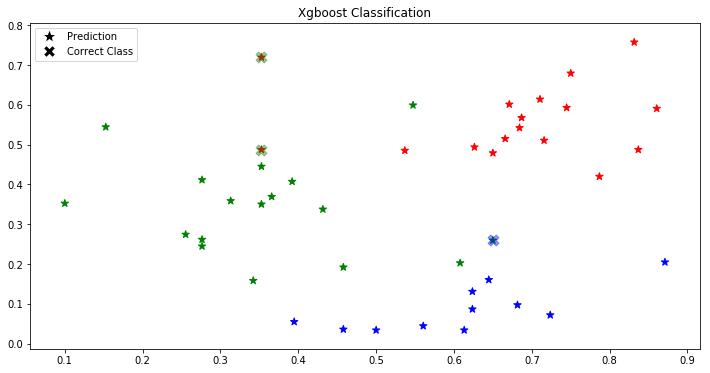

In [30]:
#Show Incorrect Classification
plot_comp_test_data(X_test, y_test, xgb_y_head, title="Xgboost Classification")

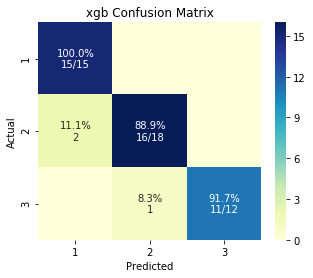

In [31]:
# Show Confusion Matrix
plot_cm(y_test, xgb_y_head, title="xgb Confusion Matrix")

**XGB CV Analysis Here**

In [32]:
scores_xgb = cross_val_score(xgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_xgb), np.std(scores_xgb)))

Accuracy: 0.970 (0.016)


In [33]:
scores_xgb

array([0.97222222, 1.        , 0.97222222, 0.97142857, 0.94285714,
       0.97222222, 0.94444444, 0.97222222, 1.        , 0.97142857,
       0.97222222, 0.94444444, 0.97222222, 0.97142857, 0.97142857])